# Predicting Student Attendance and Analyzing Influencing Factors at New York Public Schools
### Ayan Karim



# Introduction


## _What is PASSNYC?_

PASSNYC is a nonprofit organization that facilitates the provision of educational services to talented individuals at underperforming schools in New York. They use public data on New York's school districts to develop programs that increase the diversity of students taking the Specialized High School Admissions Test (SHSAT) for placement in specialized high schools so that talented students can have access to greater educational opportunity despite their social circumstance. 

PASSNYC would like to breakdown obstacles preventing students from taking SHSAT by developing outreach programs to under privileged schools. They face challenges in assessing barriers preventing students from taking the SHSAT. Their solutions include funding school programs, test preparations, mentoring and resources for parents.

## _Description of Data_

The chosen raw data set can be found on Kaggle at https://www.kaggle.com/passnyc/data-science-for-good. It contains 161 columns of continuous information on demographics, school quality, attendance, truancy, academic proficiency scores and school income estimates. From that information PASSNYC derived an Economic Need Index that basically quantitatively rates schools on how much they need help. All the ratings, including the Economic Need Index, are rated on a scale from 0 to 1, converted from a scale of 100%. The Data set also includes categorical information on the city, district and address of the schools as well as school quality ratings that accompany the continuous percent ratings of the same criteria. For example, a "Rigorous Instruction %" column may have a rating of 89% for a school, and it's qualitative rating would be "Meeting Target". The data set also includes over 100 columns of dummy variables that are separated by grade, subject and demographic. 

## _Problem Statement_

My objective is to use the PASSNYC data to build a regression model that predicts Student Attendance Rates and then to interpret the results and identify factors influence school attendance. Furthermore, I'll build a classification model to categorically identify schools that have problems with attendance.

## _Implications of Data_

This product is primarily developed for PASSNYC, who can use this information to target schools that need their attention and help outline their strategies for developing after school programs that increase attendance and, in turn, increase registration in the SHSAT. Specifically, my model will help these organizations identify schools that have high a risk of developing attendance problems by using indicators to predict their attendance. PASSNYC can use this information to target those schools and make adjustments to the programs they fund.

# Research Questions

_1. What factors influence student attendance rate at a given school?_

_2. Using these factors as indicators, can we identify schools that are in danger of low participation in educational opportunities due to low attendance rates?_

# Success Metric

1. Our Regression Model must accurately predict Student Attendance Rate with at least 85% accuracy with cross validation scores ranging at most a 3% difference.

2. Our Classification Model must accurately predict "Low Attendance" Schools at least 90% accuracy, with Type I and Type II errors below 6%.

In [1]:
# Import Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import ensemble
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

%matplotlib inline

# Read Data
df = pd.read_csv('2016 School Explorer.csv')

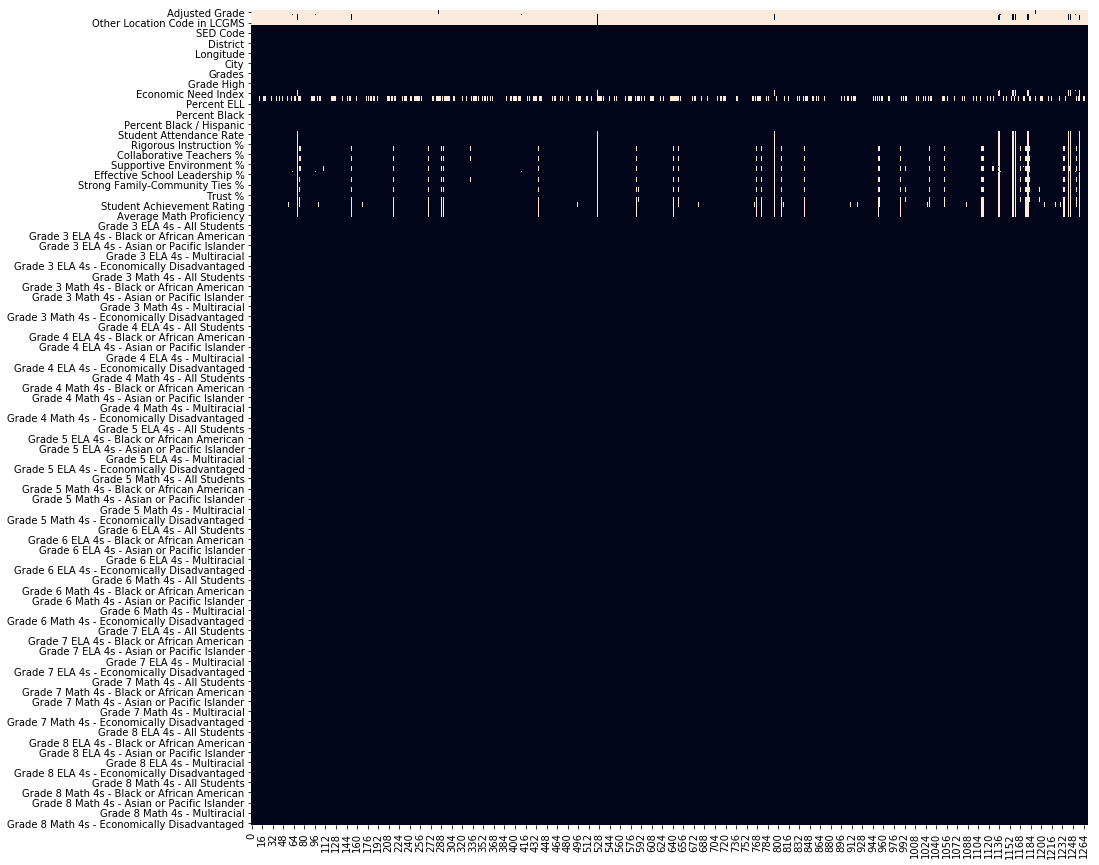

In [2]:
# Visualize Null values via HeatMap
plt.figure(figsize=(15,15))
sns.heatmap(df.T.isnull(), cbar=False)

# Data Cleaning

There were various problems with the data set including null values, symbols (such as dollar signs, percent symbols and commas) object data that was meant to be numeric and empty/incomplete columns. 

To clean the data, I dropped all the rows with null values while still maintaining a representative sample. I converted all the percentage ratings to values between 0 and 1 and removed any unwanted symbols. All variables that were meant to be continuous were converted to numeric variables.

Furthermore, all rows where "Student Attendance Rate" was equal to 0 was removed because they were outliers that indicated errors in data collection as it's not very likely for there to be an active school that has no attendance.

Finally, there were numerous dummy variables on grade and demographic that were removed because they were incomplete and slowed down the models' performance.

In [3]:
# Sort values by District
df = df.sort_values(by = 'District')

# Clean "School income estimate" by removing all dollar symbols
df['School Income Estimate'] = df['School Income Estimate'].str.replace('$', '')

# Clean "School income estimate" by removing all commas
df['School Income Estimate'] = df['School Income Estimate'].str.replace(',', '')

# Drop Unnecessary columns
df = df.drop(columns=df.loc[:,'Grade 3 ELA - All Students Tested': 'Grade 8 Math 4s - Economically Disadvantaged'].columns.tolist())

# Remove all rows in "School Income Estimate" and "Economic Need Index" with NaN
df = df[pd.notnull(df['School Income Estimate'])]
df = df[pd.notnull(df['Economic Need Index'])]
df = df[pd.notnull(df['Rigorous Instruction Rating'])]
df = df[pd.notnull(df['Collaborative Teachers Rating'])]
df = df[pd.notnull(df['Supportive Environment Rating'])]
df = df[pd.notnull(df['Effective School Leadership Rating'])]
df = df[pd.notnull(df['Strong Family-Community Ties Rating'])]
df = df[pd.notnull(df['Trust Rating'])]
df = df[pd.notnull(df['Student Achievement Rating'])]

# Change all "School Income Estimate" types to Float
df['School Income Estimate'] = pd.to_numeric(df['School Income Estimate'])

# Change all Percents to Decimals and Floats
def p2f(x):
    return float(x.strip('%'))/100
df['Percent ELL'] = df['Percent ELL'].apply(p2f)
df['Percent Asian'] = df['Percent Asian'].apply(p2f)
df['Percent Black'] = df['Percent Black'].apply(p2f)
df['Percent Hispanic'] = df['Percent Hispanic'].apply(p2f)
df['Percent Black / Hispanic'] = df['Percent Black / Hispanic'].apply(p2f)
df['Percent White'] = df['Percent White'].apply(p2f)
df['Student Attendance Rate'] = df['Student Attendance Rate'].apply(p2f)
df['Percent of Students Chronically Absent'] = df['Percent of Students Chronically Absent'].apply(p2f)
df['Rigorous Instruction %'] = df['Rigorous Instruction %'].apply(p2f)
df['Collaborative Teachers %'] = df['Collaborative Teachers %'].apply(p2f)
df['Supportive Environment %'] = df['Supportive Environment %'].apply(p2f)
df['Effective School Leadership %'] = df['Effective School Leadership %'].apply(p2f)
df['Strong Family-Community Ties %'] = df['Strong Family-Community Ties %'].apply(p2f)
df['Trust %'] = df['Trust %'].apply(p2f)

# Change grading scale froom not, approaching, meeting and exceeding target to 0, 1, 2, 3 respectively.
mapping = {'Not Meeting Target': 0, 'Approaching Target': 1, 'Meeting Target': 2, 'Exceeding Target': 3}
df = df.replace({'Rigorous Instruction Rating': mapping, 'Collaborative Teachers Rating': mapping, 'Supportive Environment Rating': mapping, 'Effective School Leadership Rating': mapping, 'Strong Family-Community Ties Rating': mapping, 'Trust Rating': mapping, 'Student Achievement Rating': mapping})

# Remove First Three columns
df = df.drop(columns=['Adjusted Grade', 'New?', 'Other Location Code in LCGMS'])

# Reindex
df = df.reset_index()

# Drop Index column
df = df.drop(columns=['index'])

# Remove rows where attendace rates are equal to 0:
df = df[df['Student Attendance Rate']>0]

In [4]:
df.head()

,School Name,SED Code,Location Code,District,Latitude,Longitude,Address (Full),City,Zip,Grades,...,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency
0,P.S. 015 ROBERTO CLEMENTE,310100010015,01M015,1,40.721834,-73.978766,"333 E 4TH ST NEW YORK, NY 10009",NEW YORK,10009,"PK,0K,01,02,03,04,05",...,3,0.91,3,0.85,2,0.94,3,1,2.14,2.17
1,GIRLS PREPARATORY CHARTER SCHOOL OF NEW YORK,310100860866,84M330,1,40.719870,-73.977376,"442 E HOUSTON ST-RM 312 NEW YORK, NY 10002",NEW YORK,10002,"0K,01,02,03,04,05",...,2,0.88,3,0.87,2,0.90,2,2,2.72,2.83
2,MANHATTAN CHARTER SCHOOL,310100860873,84M320,1,40.718230,-73.984082,"100 ATTORNEY ST NEW YORK, NY 10002",NEW YORK,10002,"0K,01,02,03,04,05",...,3,0.88,3,0.89,2,0.97,3,3,2.51,3.03
3,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",310100011539,01M539,1,40.719500,-73.979239,"111 COLUMBIA ST NEW YORK, NY 10002",NEW YORK,10002,"0K,01,02,03,04,05,06,07,08,09,10,11,12",...,2,0.55,0,0.81,1,0.74,0,3,3.83,4.03
4,NEIGHBORHOOD SCHOOL,310100010363,01M363,1,40.724404,-73.986360,"121 E 3RD ST NEW YORK, NY 10009",NEW YORK,10009,"PK,0K,01,02,03,04,05",...,2,0.96,3,0.95,3,0.99,3,1,2.55,2.68


# Exploratory Data Analysis

In [5]:
pd.set_option("display.max_columns", 999)
df.describe()

,SED Code,District,Latitude,Longitude,Zip,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Rigorous Instruction Rating,Collaborative Teachers %,Collaborative Teachers Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership %,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust %,Trust Rating,Student Achievement Rating,Average ELA Proficiency,Average Math Proficiency
count,7.900000e+02,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000,790.000000
mean,3.296357e+11,16.865823,40.728447,-73.918682,10842.417722,0.663118,48873.008949,0.129215,0.126506,0.300127,0.398747,0.698785,0.152468,0.935582,0.209722,0.908342,2.006329,0.886709,2.191139,0.904203,2.073418,0.808114,1.892405,0.848759,1.718987,0.906291,2.112658,1.931646,2.548608,2.724190
std,1.232550e+10,9.312473,0.087257,0.085222,527.257246,0.224970,21480.837500,0.109431,0.184412,0.291650,0.260253,0.307053,0.217333,0.023639,0.120781,0.046952,0.744195,0.067831,0.690455,0.055156,0.684559,0.096597,0.877731,0.044505,0.766550,0.057957,0.772609,0.677643,0.347498,0.437919
min,3.101000e+11,1.000000,40.508835,-74.244025,10001.000000,0.059000,18409.760000,0.000000,0.000000,0.000000,0.020000,0.030000,0.000000,0.860000,0.000000,0.680000,0.000000,0.550000,0.000000,0.650000,0.000000,0.340000,0.000000,0.720000,0.000000,0.620000,0.000000,0.000000,1.970000,1.900000
25%,3.209000e+11,9.000000,40.665454,-73.960074,10453.000000,0.531500,33668.392500,0.040000,0.010000,0.050000,0.170000,0.410000,0.010000,0.920000,0.110000,0.880000,1.000000,0.850000,2.000000,0.870000,2.000000,0.760000,1.000000,0.820000,1.000000,0.880000,2.000000,1.000000,2.270000,2.360000
50%,3.317000e+11,17.000000,40.715283,-73.921372,11205.000000,0.729000,43879.400000,0.100000,0.040000,0.200000,0.340000,0.870000,0.030000,0.940000,0.190000,0.910000,2.000000,0.900000,2.000000,0.910000,2.000000,0.830000,2.000000,0.840000,2.000000,0.920000,2.000000,2.000000,2.480000,2.650000
75%,3.425000e+11,25.000000,40.809216,-73.875092,11233.750000,0.849000,59429.877500,0.180000,0.160000,0.530000,0.630000,0.960000,0.230000,0.950000,0.300000,0.940000,3.000000,0.940000,3.000000,0.950000,3.000000,0.880000,3.000000,0.870000,2.000000,0.950000,3.000000,2.000000,2.780000,3.037500
max,3.531009e+11,32.000000,40.903455,-73.708920,11694.000000,0.957000,181382.060000,0.660000,0.950000,0.970000,0.980000,0.990000,0.920000,1.000000,0.570000,1.000000,3.000000,1.000000,3.000000,1.000000,3.000000,0.990000,3.000000,0.990000,3.000000,1.000000,3.000000,3.000000,3.930000,4.150000


In [6]:
# Create a Pearson Correlation Matrix for Demographic Variables
student_demographic = df[['Economic Need Index', 'Student Attendance Rate', 'School Income Estimate', 'Percent ELL', 'Percent Asian','Percent Black', 'Percent Hispanic', 'Percent Black / Hispanic', 'Percent White']]
student_demographic.corr()

,Economic Need Index,Student Attendance Rate,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White
Economic Need Index,1.000000,-0.612174,-0.891596,0.411252,-0.324299,0.318007,0.564841,0.780189,-0.779573
Student Attendance Rate,-0.612174,1.000000,0.489698,0.048046,0.493046,-0.390761,-0.255374,-0.586982,0.393568
School Income Estimate,-0.891596,0.489698,1.000000,-0.352614,0.243730,-0.274523,-0.498412,-0.682180,0.706577
Percent ELL,0.411252,0.048046,-0.352614,1.000000,0.279981,-0.440487,0.532910,0.032305,-0.245283
Percent Asian,-0.324299,0.493046,0.243730,0.279981,1.000000,-0.453865,-0.304923,-0.688966,0.110353
Percent Black,0.318007,-0.390761,-0.274523,-0.440487,-0.453865,1.000000,-0.384381,0.623432,-0.490667
Percent Hispanic,0.564841,-0.255374,-0.498412,0.532910,-0.304923,-0.384381,1.000000,0.482011,-0.384778
Percent Black / Hispanic,0.780189,-0.586982,-0.682180,0.032305,-0.688966,0.623432,0.482011,1.000000,-0.791712
Percent White,-0.779573,0.393568,0.706577,-0.245283,0.110353,-0.490667,-0.384778,-0.791712,1.000000


If we investigate a pair plot of the student demographics data, we see that many of our variables have skewness with outliers. This makes sense because a normal distribution of demographic data would imply an equal and diverse representation of races at schools. The outliers indicate that there are more students of a certain demographic, such as "white", than others.

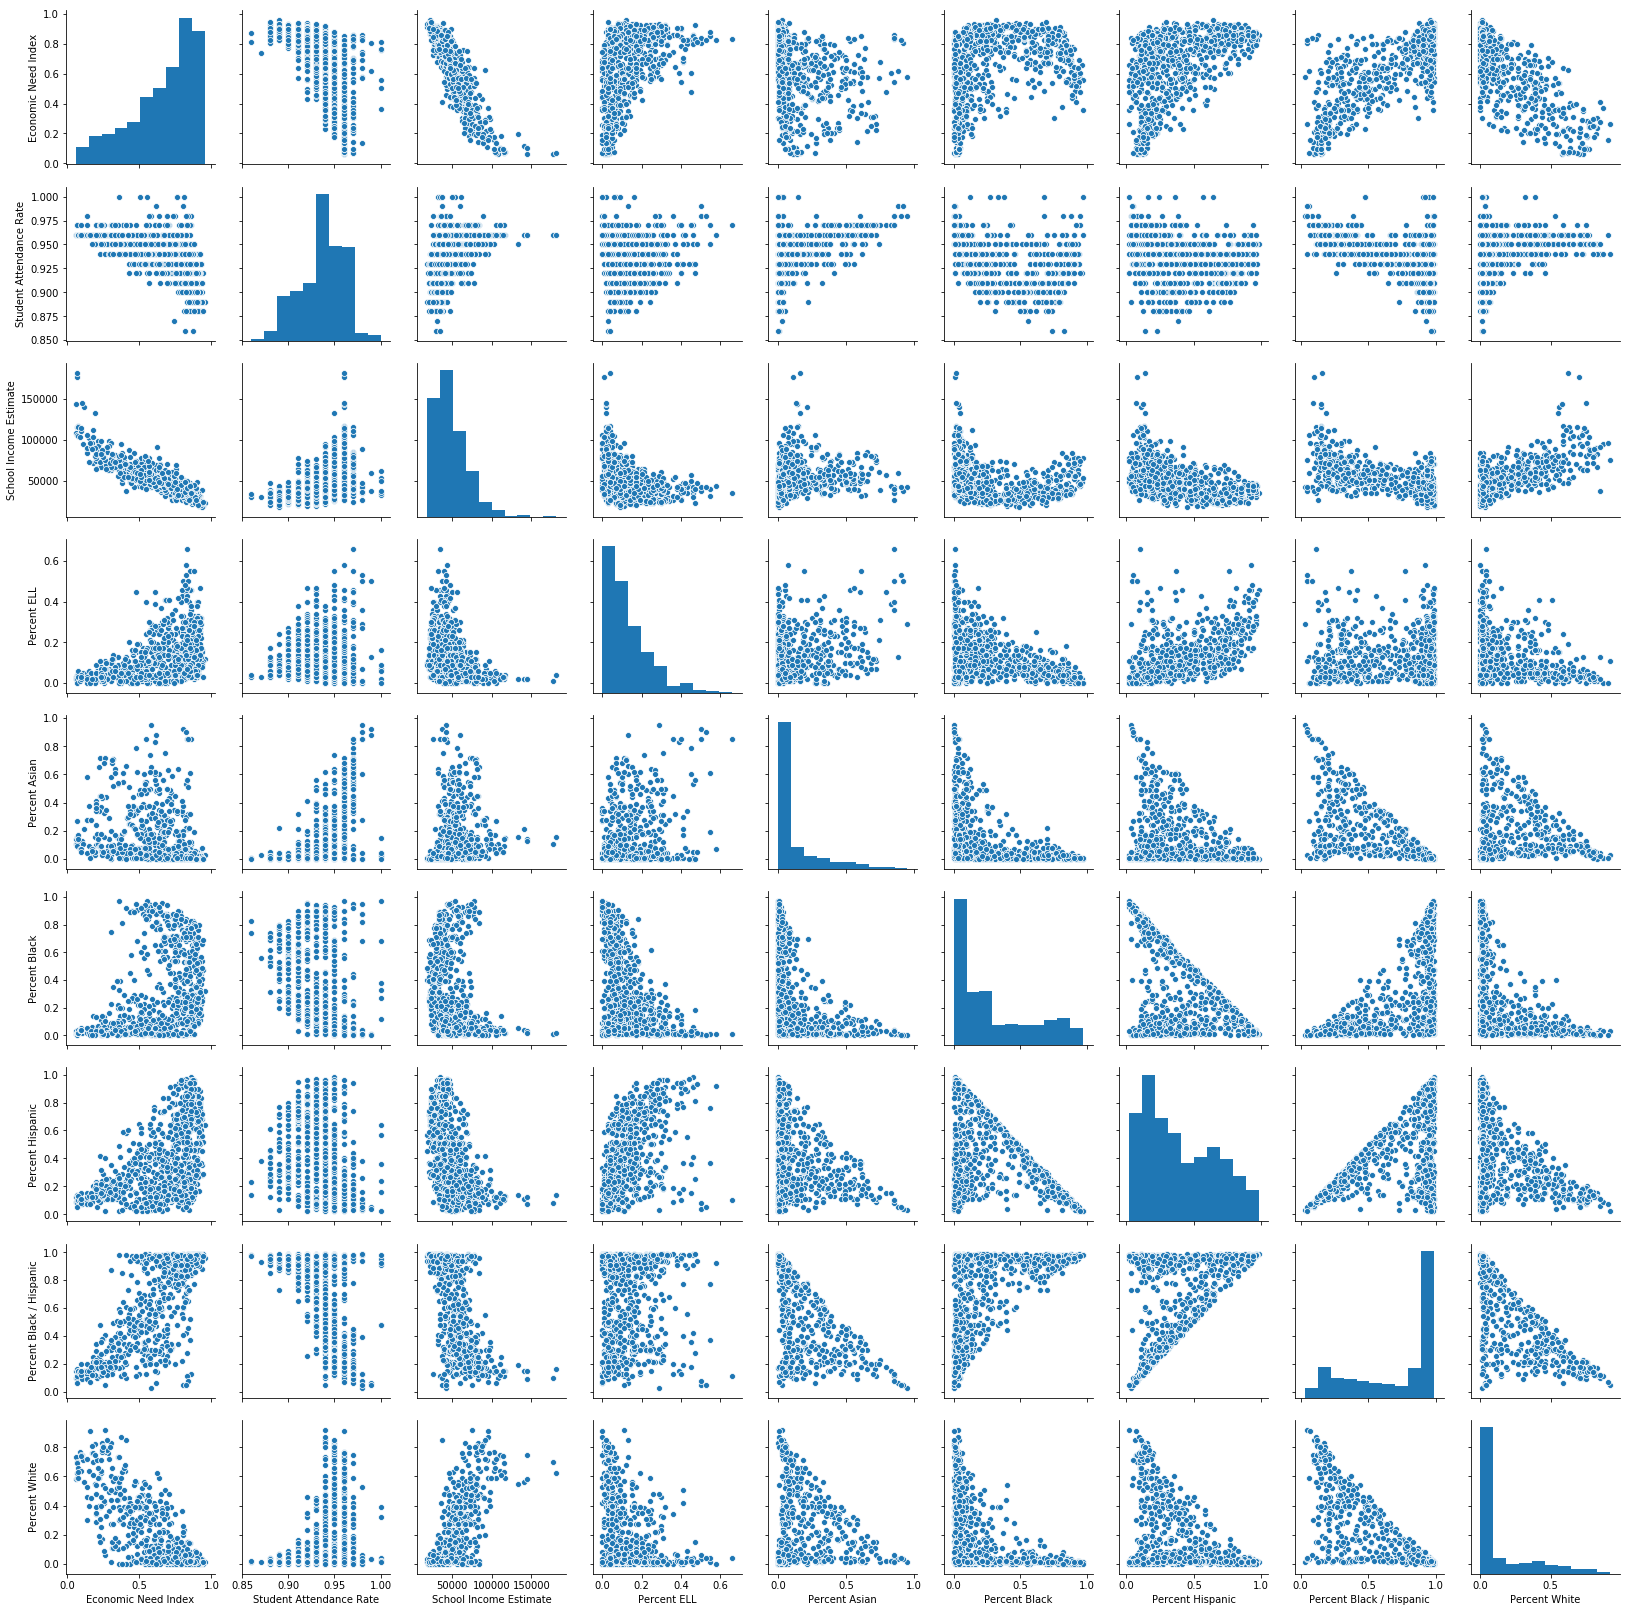

In [7]:
# Display correlations
sns.pairplot(student_demographic)

In [8]:
# Pearson correlation matrix of ENI vs. School performance
school_rating = df[['Economic Need Index', 'Student Attendance Rate', 'Percent of Students Chronically Absent', 'Rigorous Instruction %', 'Collaborative Teachers %', 'Supportive Environment %', 'Effective School Leadership %', 'Strong Family-Community Ties %', 'Trust %']]
school_rating.corr()

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %
Economic Need Index,1.000000,-0.612174,0.679742,-0.263544,-0.237858,-0.361685,-0.231725,-0.334910,-0.187854
Student Attendance Rate,-0.612174,1.000000,-0.966396,0.143558,0.207265,0.306179,0.247566,0.188143,0.228648
Percent of Students Chronically Absent,0.679742,-0.966396,1.000000,-0.171348,-0.226812,-0.317283,-0.263253,-0.218471,-0.239110
Rigorous Instruction %,-0.263544,0.143558,-0.171348,1.000000,0.698617,0.616720,0.597702,0.265528,0.533321
Collaborative Teachers %,-0.237858,0.207265,-0.226812,0.698617,1.000000,0.608913,0.908595,0.408199,0.875808
Supportive Environment %,-0.361685,0.306179,-0.317283,0.616720,0.608913,1.000000,0.516207,0.307945,0.583834
Effective School Leadership %,-0.231725,0.247566,-0.263253,0.597702,0.908595,0.516207,1.000000,0.443771,0.879225
Strong Family-Community Ties %,-0.334910,0.188143,-0.218471,0.265528,0.408199,0.307945,0.443771,1.000000,0.413765
Trust %,-0.187854,0.228648,-0.239110,0.533321,0.875808,0.583834,0.879225,0.413765,1.000000


A second pair plot of variables rating school quality show near normal distributions, including our target variable, "Student Attendance Rate". We also see some multicollinearity between certain variables like "Collaborative Teachers %", "Effective School Leadership %" and "Trust %". We should consider combining these variables in our feature engineering since they're highly correlated. We want to avoid high multi-collinearity between variables if we want to employ an OLS regression model.

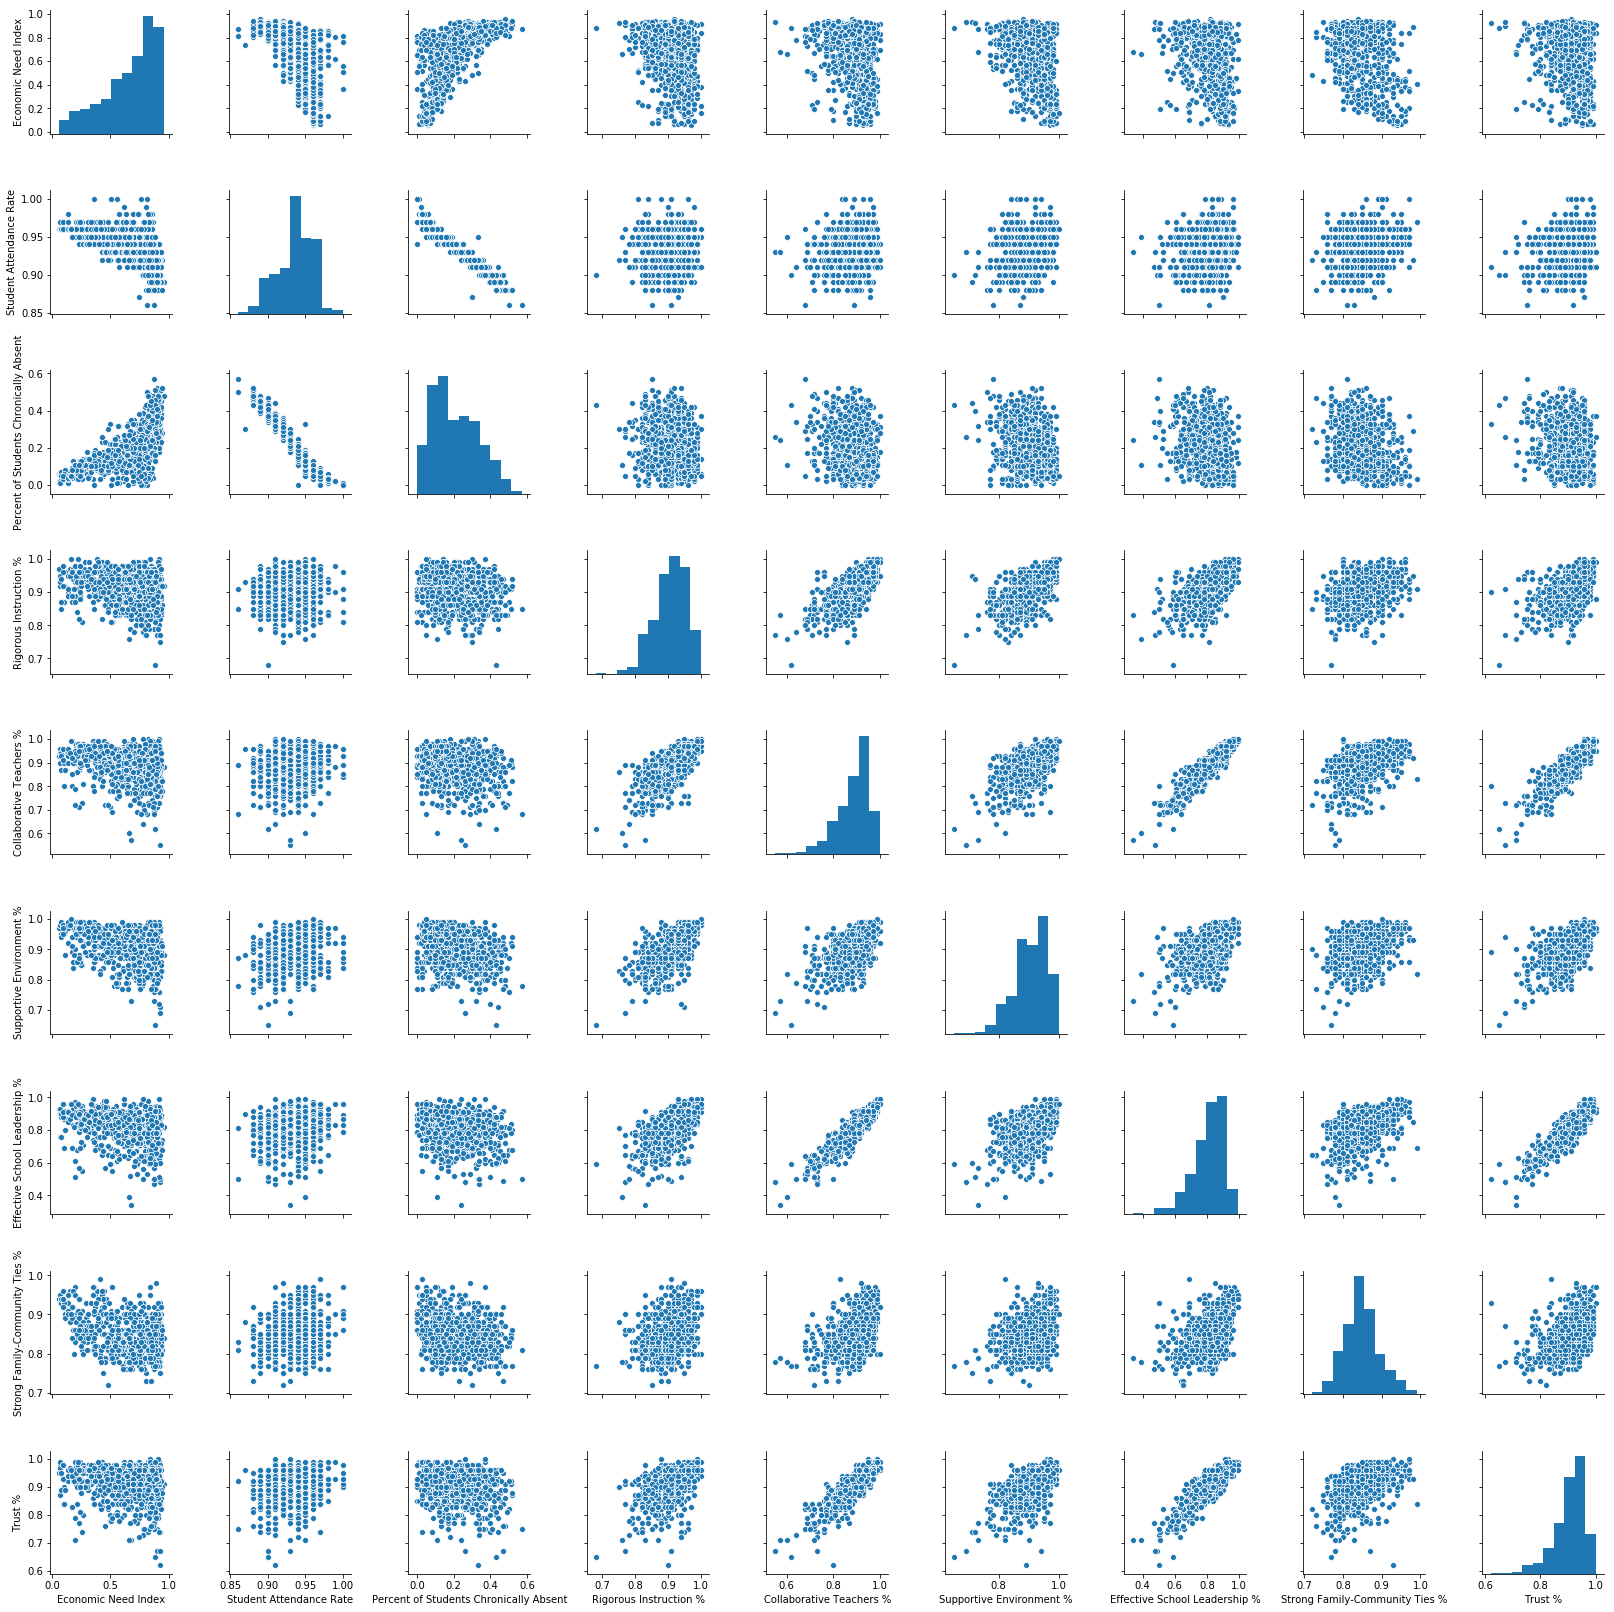

In [9]:
# Visualize correlations
sns.pairplot(school_rating)

The histogram of our target variable, "Chronically Absent Rates" shows a nearly normal distribution, which satisfies our assumption on normality for our OLS model.

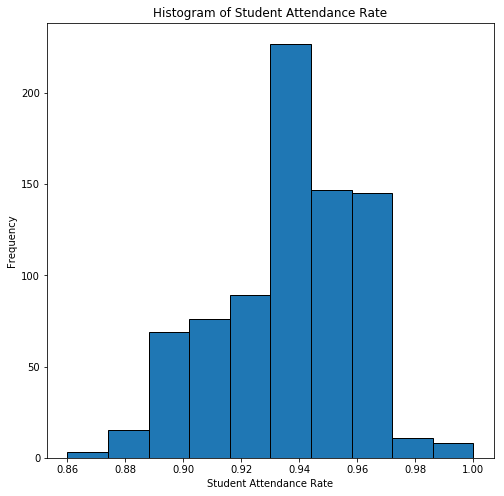

In [10]:
# Histogram of Student Attendance rates (Target variable) 
plt.figure(figsize=(8,8))
plt.hist(df['Student Attendance Rate'], edgecolor='k')
plt.title('Histogram of Student Attendance Rate')
plt.xlabel('Student Attendance Rate')
plt.ylabel('Frequency')
plt.show()

# Feature Engineering and Selection

For our feature engineering, we'll create a new data frame that includes all the continuous variable data as well as a one-hot encoding of important categorical data, such as city and district. We'll train our baseline regression model on this data and then engineer more features to optimize the accuracy of our models. 

In the code below, I've dropped many unnecessary columns such as location, zip code, address, SED code, etc. Then I did a one-hot encoding of district and city to identify the location of the schools in a binary format.

In [11]:
# Create Features Data Frame
features = df.drop(columns=['SED Code', 'Location Code', 'Address (Full)', 'Grades', 'Grade Low', 'Grade High', 'Zip'])

# Create one-hot encoding for categorical variables
features = pd.get_dummies(features, columns=['District', 'City', 'Community School?'])

## Establish Baseline models

First, we'll train our baseline regression models on the feature data set we already have. Then I'll rank the significance of each variable as an indicator in our model and filter out less significant variables that compromises the efficiency of our model more so than actually improving it. Lastly, I'll combine highly correlated features to reduce multicollinearity.

The regression models used here are simple OLS and Gradient Boosted Regression model. These two models have shown the highest baseline accuracies amongst the regression models tested. Then we'll decide on the best model based on accuracy and consistent.

The models are trained 80% of our data, then tested on a hold-out group of 20% of the data. I'll also cross-validate our sample in 5 groups. This process is repeated until we can no longer improve our models, so that we can optimize both the predictive power and consistency of the models.

In [12]:
# Instantiate an OLS Regression
lg = LinearRegression()

# Define predictor and target variables
x = features.drop(columns=['School Name', 'Student Attendance Rate'])
y = features['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
lg.fit(x_train, y_train)

# Score model on test set
print("Accuracy = " + str(lg.score(x_test, y_test)))

# Cross Validate
print("Cross-validation Score = " + str(cross_val_score(lg, x, y, cv=5)))

Accuracy = 0.891782600000575
Cross-validation Score = [0.92356628 0.87946075 0.92524156 0.94884494 0.88273549]


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### OLS Baseline

OLS prediction scores very highly on this data set at 89.17% on our test set which satisfies our success metric of at least 85%. But its cross-validation scores range between 87% and 95%, which is an 8% difference. 

We also need to check to see if underlying assumptions are met of this model.

In [13]:
# Instantiate a Gradient Boosting Regression
gbr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=2, learning_rate=0.1)

# Define predictor and target variables
x = features.drop(columns=['School Name', 'Student Attendance Rate'])
y = features['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
gbr.fit(x_train, y_train)

# Score model on test set
print("Accuracy = " + str(gbr.score(x_test, y_test)))

# Cross Validate
print("Cross-validation Score = " + str(cross_val_score(gbr, x, y, cv=5)))

Accuracy = 0.8806368582722469
Cross-validation Score = [0.91129568 0.87356775 0.92484778 0.95171415 0.92334616]


### Gradient Boosting Regressor Baseline

The Gradient Boosted Weak Learners model also looks really strong in the same respect as the OLS. The predictive power on the test set is high at 88.17% and the cross-validation scores range between 87% and 95%. Both OLS and the Weak Learners model should improve in both accuracy and consistency through further feature engineering.

## OLS Feature Selection

In [14]:
# Pass linear regression model to the RFE constructor
selector = RFE(lg)
selector = selector.fit(features.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,Latitude,City_BAYSIDE,City_MIDDLE VILLAGE,City_LITTLE NECK,City_KEW GARDENS,District_9,City_JACKSON HEIGHTS,City_HOWARD BEACH,District_14,City_HOLLIS,District_17,City_FLUSHING,District_4,City_DOUGLASTON,District_24,City_CORONA,District_26,City_COLLEGE POINT,City_CAMBRIA HEIGHTS,District_29,District_30,City_BRONX,District_32,City_ARVERNE,City_ASTORIA,District_23,City_QUEENS VILLAGE,City_NEW YORK,City_SAINT ALBANS,Economic Need Index,City_WOODSIDE,Percent ELL,Percent Black,Percent Hispanic,City_WHITESTONE,Percent White,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,District_1,Supportive Environment %,City_BROAD CHANNEL,City_ROSEDALE,Average Math Proficiency,Average ELA Proficiency,City_REGO PARK,City_ROCKAWAY BEACH,City_ROCKAWAY PARK,City_ROOSEVELT ISLAND,Strong Family-Community Ties %,Effective School Leadership %,Effective School Leadership Rating,City_ELMHURST,City_OZONE PARK,District_20,District_13,District_16,District_18,District_11,City_SOUTH RICHMOND HILL,Percent Asian,Longitude,District_27,District_5,City_LONG ISLAND CITY,Percent Black / Hispanic,City_JAMAICA,City_FLORAL PARK,District_10,City_WOODHAVEN,City_FAR ROCKAWAY,City_BROOKLYN,District_31,City_SPRINGFIELD GARDENS,City_SOUTH OZONE PARK,City_GLENDALE,City_MASPETH,Student Achievement Rating,City_EAST ELMHURST,Collaborative Teachers Rating,Rigorous Instruction Rating,City_RICHMOND HILL,Strong Family-Community Ties Rating,City_STATEN ISLAND,District_25,District_28,District_21,District_22,District_3,District_6,District_12,City_RIDGEWOOD,Community School?_No,Trust %,City_BELLEROSE,District_15,Trust Rating,District_8,Community School?_Yes,District_7,District_19,City_FOREST HILLS,District_2,Supportive Environment Rating,School Income Estimate
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54


In [15]:
# Drop Insignificant columns from features
features_lg = features.drop(columns=['District_14', 'District_1', 'City_WOODSIDE', 'City_ELMHURST', 'City_OZONE PARK', 'District_20', 'District_13', 'District_16', 'District_18', 'District_11', 'City_SOUTH RICHMOND HILL', 'Percent Asian', 'Longitude', 'District_27', 'District_5', 'City_LONG ISLAND CITY', 'Percent Black / Hispanic', 'City_JAMAICA', 'City_FLORAL PARK', 'District_10', 'City_WOODHAVEN', 'City_FAR ROCKAWAY', 'City_BROOKLYN', 'District_31', 'City_SPRINGFIELD GARDENS', 'City_SOUTH OZONE PARK', 'City_GLENDALE', 'City_MASPETH', 'Student Achievement Rating', 'City_EAST ELMHURST', 'Collaborative Teachers Rating', 'Rigorous Instruction Rating', 'City_RICHMOND HILL', 'Strong Family-Community Ties Rating', 'City_STATEN ISLAND', 'District_25', 'District_28', 'District_21', 'District_22', 'District_3', 'District_6', 'District_12', 'City_RIDGEWOOD', 'Community School?_No', 'Trust %', 'City_BELLEROSE', 'District_15', 'Trust Rating', 'District_8', 'Community School?_Yes', 'District_7', 'District_19', 'City_FOREST HILLS', 'District_2', 'Supportive Environment Rating', 'School Income Estimate'])

# Instantiate an OLS Regression
lg = LinearRegression()

# Define predictor and target variables
x = features_lg.drop(columns=['School Name', 'Student Attendance Rate'])
y = features_lg['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
lg.fit(x_train, y_train)

# Score model on test set
print("Accuracy = " + str(lg.score(x_test, y_test)))

# Cross Validate
print("Cross-validation Score = " + str(cross_val_score(lg, x, y, cv=5)))

Accuracy = 0.9033819727920441
Cross-validation Score = [0.9222804  0.912493   0.92915372 0.95441088 0.91763673]


In [16]:
# Pass linear regression model to the RFE constructor
selector = RFE(lg)
selector = selector.fit(features_lg.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features_lg.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,City_ARVERNE,City_SAINT ALBANS,City_DOUGLASTON,City_KEW GARDENS,City_LITTLE NECK,District_23,City_MIDDLE VILLAGE,District_4,Average Math Proficiency,City_CAMBRIA HEIGHTS,Strong Family-Community Ties %,Average ELA Proficiency,City_ROCKAWAY PARK,Supportive Environment %,City_ROOSEVELT ISLAND,Rigorous Instruction %,Percent of Students Chronically Absent,Percent White,Percent Hispanic,Percent Black,City_ROSEDALE,Economic Need Index,City_ROCKAWAY BEACH,City_BROAD CHANNEL,City_HOLLIS,District_29,District_17,City_ASTORIA,Latitude,City_CORONA,District_24,City_WHITESTONE,Percent ELL,City_JACKSON HEIGHTS,District_30,City_REGO PARK,City_BRONX,City_BAYSIDE,City_FLUSHING,City_COLLEGE POINT,City_NEW YORK,District_32,District_9,City_HOWARD BEACH,District_26,City_QUEENS VILLAGE,Collaborative Teachers %,Effective School Leadership %,Effective School Leadership Rating
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26


In [17]:
# Drop Insignificant columns from features
features_lg = features_lg.drop(columns=['District_29', 'District_17', 'City_ASTORIA', 'Latitude', 'City_CORONA', 'District_24', 'City_WHITESTONE', 'Percent ELL', 'City_JACKSON HEIGHTS', 'District_30', 'City_REGO PARK', 'City_BRONX', 'City_BAYSIDE', 'City_FLUSHING', 'City_COLLEGE POINT', 'City_NEW YORK', 'District_32', 'District_9', 'City_HOWARD BEACH', 'District_26', 'City_QUEENS VILLAGE', 'Collaborative Teachers %', 'Effective School Leadership %', 'Effective School Leadership Rating'])

# Instantiate an OLS Regression
lg = LinearRegression()

# Define predictor and target variables
x = features_lg.drop(columns=['School Name', 'Student Attendance Rate'])
y = features_lg['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
lg.fit(x_train, y_train)

# Score model on test set
print("Accuracy = " + str(lg.score(x_test, y_test)))

# Cross Validate
print("Cross-validation Score = " + str(cross_val_score(lg, x, y, cv=5)))

Accuracy = 0.9025066380714785
Cross-validation Score = [0.9298698  0.91009361 0.92963778 0.961826   0.92038088]


From our process of reducing features in our model based on importance, we've improved the accuracy of the model on our test set to 90.25% and our minimum accuracy score on our holdout-groups in the cross validation is 91%. Furthermore, the consistency has also improved as our cross-validation scores now range from 91% to 96%. That's a total difference range of 4%, which is less than 8% from our baseline model. This is a vast improvement on our baseline models and nearly satisfies our success metrics. The cross-validation range is only 1% higher than our desired variance of 3%.

Next, we can combine our "Average ELA Proficiency" and "Average Math Proficiency" variables because they're highly correlated at 94.8%. This is bad because our OLS model assumes independence between the predictor variables.

In [18]:
# Combining Features Average ELA proficiency and Average Math Proficiency
means = df[['Average ELA Proficiency', 'Average Math Proficiency']].mean(axis=0)
stds = df[['Average ELA Proficiency', 'Average Math Proficiency']].std(axis=0)
features_lg['ELA_Math_Proficiency'] = ((df[['Average ELA Proficiency', 'Average Math Proficiency']]-means)/stds).mean(axis=1)
features_lg = features_lg.drop(columns=['Average ELA Proficiency', 'Average Math Proficiency'])

# Instantiate an OLS Regression
lg = LinearRegression()

# Define predictor and target variables
x = features_lg.drop(columns=['School Name', 'Student Attendance Rate'])
y = features_lg['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
lg.fit(x_train, y_train)

# Predict
y_pred = lg.predict(x_test)

# Score model on test set
print("Accuracy = " + str(lg.score(x_test, y_test)))

# Cross Validate
print("Cross-validation Score = " + str(cross_val_score(lg, x, y, cv=5)))

Accuracy = 0.9049483907586057
Cross-validation Score = [0.92803857 0.90830921 0.93184103 0.96059266 0.91805489]


Combining the Math and ELA proficiency variables actually improved the test score to 90.49%, although it's very small improvement. There isn't much improvement in the consistency of the cross-validation scores.

### Validate Underlying Assumptions of OLS Regression


We need to validate the assumptions of the OLS Regression. We've already corrected for high multi-collinearity between predictors, now we need to ensure that the errors are distributed normally and low heteroskedasticity. From our visualizations below, we can see that the residual errors have a normal distribution however there are a few outliers between -0.03 and -0.05. Our scatter plot also shows that the variance in our errors are mostly homogenous, except for two or three outliers.

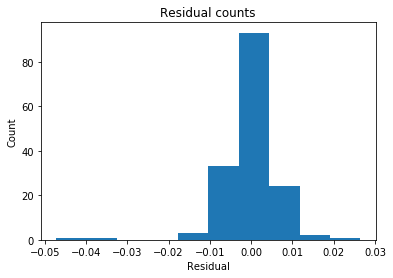

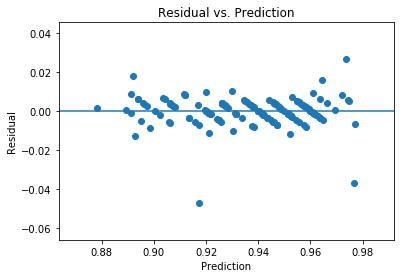

RMSE = 0.007129916229129946


In [19]:
# Predict
prediction = lg.predict(x_test).ravel()

# Actual data
actual = y_test

# Residuals
residual = actual - prediction

# Distribution of residual errors
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

# Scatterplot of Residual Error Variance
plt.scatter(prediction, residual)
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Prediction')
plt.show()

# RMSE of linear regression
from sklearn import metrics
print("RMSE = " + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

## Ensemble Model Feature Selection

In [20]:
# Pass linear regression model to the RFE constructor
selector = RFE(gbr)
selector = selector.fit(features.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,Latitude,District_16,District_17,City_SAINT ALBANS,City_WOODSIDE,City_WOODHAVEN,City_WHITESTONE,City_STATEN ISLAND,City_SPRINGFIELD GARDENS,City_SOUTH RICHMOND HILL,City_COLLEGE POINT,City_CORONA,City_DOUGLASTON,City_EAST ELMHURST,City_ELMHURST,City_FAR ROCKAWAY,City_FLORAL PARK,City_FOREST HILLS,City_GLENDALE,City_HOLLIS,City_HOWARD BEACH,City_LITTLE NECK,City_ROCKAWAY BEACH,City_ROCKAWAY PARK,City_ROOSEVELT ISLAND,City_ROSEDALE,District_15,District_4,District_23,City_SOUTH OZONE PARK,Supportive Environment Rating,Collaborative Teachers %,Rigorous Instruction Rating,Rigorous Instruction %,Percent of Students Chronically Absent,Percent White,Percent Black / Hispanic,Percent Hispanic,Percent Black,Effective School Leadership %,Strong Family-Community Ties %,Trust %,Supportive Environment %,Student Achievement Rating,Collaborative Teachers Rating,Longitude,Economic Need Index,Average ELA Proficiency,School Income Estimate,Average Math Proficiency,Percent Asian,Percent ELL,City_KEW GARDENS,City_JACKSON HEIGHTS,City_RICHMOND HILL,City_LONG ISLAND CITY,Strong Family-Community Ties Rating,Effective School Leadership Rating,District_18,City_FLUSHING,City_MASPETH,City_JAMAICA,Trust Rating,District_19,City_RIDGEWOOD,District_20,City_MIDDLE VILLAGE,City_REGO PARK,City_CAMBRIA HEIGHTS,District_2,District_1,District_21,City_QUEENS VILLAGE,City_NEW YORK,District_3,City_OZONE PARK,City_BROOKLYN,District_5,City_BRONX,District_6,City_BROAD CHANNEL,District_7,City_BELLEROSE,District_8,City_BAYSIDE,District_9,City_ASTORIA,District_10,City_ARVERNE,District_11,District_32,District_12,District_31,District_14,District_13,District_22,Community School?_No,Community School?_Yes,District_30,District_24,District_29,District_25,District_28,District_26,District_27
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54


In [21]:
# Drop Insignificant columns from features
features_gbr = features.drop(columns=['City_LITTLE NECK', 'Student Achievement Rating', 'District_20', 'City_RICHMOND HILL', 'District_21', 'City_MIDDLE VILLAGE', 'City_NEW YORK', 'City_COLLEGE POINT', 'District_1', 'City_CAMBRIA HEIGHTS', 'District_2', 'District_3', 'District_22', 'City_OZONE PARK', 'City_QUEENS VILLAGE', 'City_BROOKLYN', 'District_5', 'City_BRONX', 'District_6', 'City_BROAD CHANNEL', 'District_7', 'City_BELLEROSE', 'District_8', 'City_BAYSIDE', 'District_9', 'City_ASTORIA', 'District_16', 'City_ARVERNE', 'District_10', 'District_32', 'District_12', 'District_31', 'District_13', 'District_30', 'District_15', 'District_14', 'Community School?_No', 'District_29', 'District_24', 'Community School?_Yes', 'District_25', 'District_28', 'District_26', 'District_27'])

# Instantiate a Gradient Boosting Regression

gbr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=2, learning_rate=0.1)

# Define predictor and target variables
x = features_gbr.drop(columns=['School Name', 'Student Attendance Rate'])
y = features_gbr['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
gbr.fit(x_train, y_train)

# Score model on test set
print("Accuracy = " + str(gbr.score(x_test, y_test)))

Accuracy = 0.8808628141321614


In [22]:
# Pass linear regression model to the RFE constructor
selector = RFE(gbr)
selector = selector.fit(features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,Latitude,City_WHITESTONE,City_STATEN ISLAND,City_SPRINGFIELD GARDENS,City_SOUTH OZONE PARK,City_ROOSEVELT ISLAND,District_17,District_4,Average Math Proficiency,Average ELA Proficiency,Trust %,Strong Family-Community Ties Rating,Effective School Leadership %,Supportive Environment Rating,Supportive Environment %,District_23,Collaborative Teachers %,Longitude,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Collaborative Teachers Rating,Percent Black,Percent Hispanic,City_WOODSIDE,Percent White,Percent of Students Chronically Absent,Percent Black / Hispanic,Rigorous Instruction %,City_CORONA,Rigorous Instruction Rating,City_ROCKAWAY BEACH,City_DOUGLASTON,City_ELMHURST,City_FLUSHING,City_WOODHAVEN,Effective School Leadership Rating,City_FAR ROCKAWAY,City_FLORAL PARK,City_ROSEDALE,City_SAINT ALBANS,Trust Rating,City_FOREST HILLS,City_ROCKAWAY PARK,City_SOUTH RICHMOND HILL,City_HOLLIS,City_MASPETH,City_JAMAICA,City_GLENDALE,City_EAST ELMHURST,District_11,City_LONG ISLAND CITY,City_KEW GARDENS,City_HOWARD BEACH,City_JACKSON HEIGHTS,Strong Family-Community Ties %,District_18,City_RIDGEWOOD,District_19,City_REGO PARK
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32


In [23]:
# Drop Insignificant columns from features
features_gbr = features_gbr.drop(columns=['City_SAINT ALBANS', 'Effective School Leadership Rating', 'City_FLUSHING', 'City_CORONA', 'City_SOUTH OZONE PARK', 'Rigorous Instruction Rating', 'City_DOUGLASTON', 'City_FAR ROCKAWAY', 'City_SPRINGFIELD GARDENS', 'City_WOODHAVEN', 'City_WHITESTONE', 'City_FLORAL PARK', 'City_ELMHURST', 'City_KEW GARDENS', 'City_ROSEDALE', 'City_ROCKAWAY BEACH', 'City_JAMAICA', 'City_SOUTH RICHMOND HILL', 'City_ROCKAWAY PARK', 'City_ROOSEVELT ISLAND', 'City_MASPETH', 'District_11', 'City_EAST ELMHURST', 'City_LONG ISLAND CITY', 'City_RIDGEWOOD', 'District_18', 'City_HOLLIS', 'City_JACKSON HEIGHTS', 'Strong Family-Community Ties %', 'District_19', 'City_HOWARD BEACH', 'City_REGO PARK', 'Trust Rating'])

# Instantiate a Gradient Boosting Regression

gbr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=2, learning_rate=0.1)

# Define predictor and target variables
x = features_gbr.drop(columns=['School Name', 'Student Attendance Rate'])
y = features_gbr['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
gbr.fit(x_train, y_train)

# Score model on test set
print("Accuracy = " + str(gbr.score(x_test, y_test)))

Accuracy = 0.8803611139907792


In [24]:
# Pass linear regression model to the RFE constructor

selector = RFE(gbr)
selector = selector.fit(features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,Latitude,Average Math Proficiency,Supportive Environment Rating,Supportive Environment %,District_23,Rigorous Instruction %,Percent of Students Chronically Absent,Percent White,Percent Black,Percent Asian,Percent ELL,School Income Estimate,Economic Need Index,Average ELA Proficiency,Trust %,Collaborative Teachers %,District_4,Percent Hispanic,Longitude,Percent Black / Hispanic,City_WOODSIDE,Effective School Leadership %,Collaborative Teachers Rating,Strong Family-Community Ties Rating,District_17,City_STATEN ISLAND,City_FOREST HILLS,City_GLENDALE
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15


In [25]:
# Combine Average ELA proficiency and Average Math Proficiency
means = df[['Average ELA Proficiency', 'Average Math Proficiency']].mean(axis=0)
stds = df[['Average ELA Proficiency', 'Average Math Proficiency']].std(axis=0)
features_gbr['ELA_Math_Proficiency'] = ((df[['Average ELA Proficiency', 'Average Math Proficiency']]-means)/stds).mean(axis=1)
features_gbr = features_gbr.drop(columns=['Average ELA Proficiency', 'Average Math Proficiency'])

# Combine School Quality Variables
means = df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']].mean(axis=0)
stds = df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']].std(axis=0)
features_gbr['School Quality'] = ((df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']]-means)/stds).mean(axis=1)
features_gbr = features_gbr.drop(columns=['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %'])

# Instantiate a Gradient Boosting Regression

gbr = ensemble.GradientBoostingRegressor(n_estimators=28, max_depth=2, learning_rate=0.1)

# Define predictor and target variables
x = features_gbr.drop(columns=['School Name', 'Student Attendance Rate'])
y = features_gbr['Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
gbr.fit(x_train, y_train)

# Score model on test set
print("Accuracy = " + str(gbr.score(x_test, y_test)))

# Cross validation
print("Cross-validation Score = " + str(cross_val_score(gbr, x, y, cv=5)))

Accuracy = 0.8963703674532486
Cross-validation Score = [0.92221072 0.91406388 0.91283775 0.92760819 0.92239649]


Our weak learners's model doesn't have as high of an accuracy score (89.64%), however it only differs by less than 1% from the OLS score (90.48%) and its cross-validation scores are far more consistent as it ranges between 91.29% and 92.22%.

In [26]:
# Pass linear regression model to the RFE constructor
selector = RFE(gbr)
selector = selector.fit(features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,School Quality,City_WOODSIDE,City_STATEN ISLAND,City_GLENDALE,City_FOREST HILLS,Percent Asian,District_23,District_17,Supportive Environment Rating,ELA_Math_Proficiency,Percent of Students Chronically Absent,Supportive Environment %,Percent White,Percent Black / Hispanic,Percent Hispanic,Percent Black,District_4,Strong Family-Community Ties Rating,Percent ELL,School Income Estimate,Economic Need Index,Longitude,Latitude
Ranking,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13


### Regression Model Conclusions

The Gradient Boosted Regression model is the more reliable model for use. This model has a combination of both high predictive power and consistent cross-validation scores that meet our success metrics of at least 85% predictive accuracy and less than 3% variance in cross-validation. 

However, although our regression model gives us an accurate prediction on the attendance rate, we aren't actually sure if that attendance rate is bad or good and whether PASSNYC should be concerned or not.

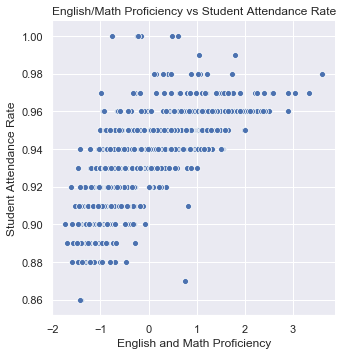

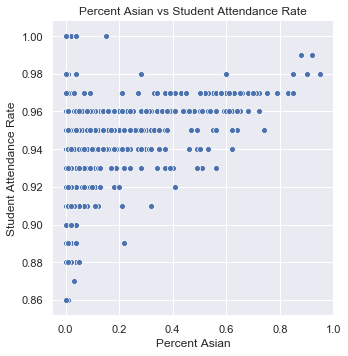

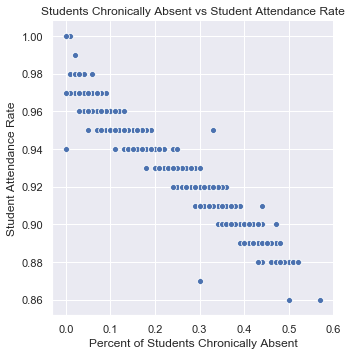

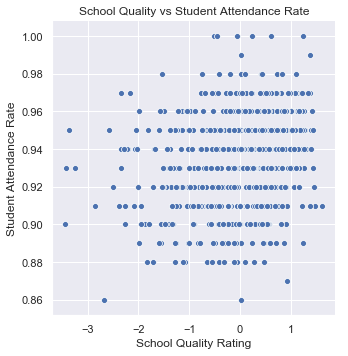

In [27]:
# Show linear relationship between target and predictors
sns.set(style="darkgrid")


sns.relplot(x='ELA_Math_Proficiency', y='Student Attendance Rate', data=features_gbr)
plt.xlabel('English and Math Proficiency')
plt.title('English/Math Proficiency vs Student Attendance Rate')
plt.show()

sns.relplot(x='Percent Asian', y='Student Attendance Rate', data=features_gbr)
plt.xlabel('Percent Asian')
plt.title('Percent Asian vs Student Attendance Rate')
plt.show()


sns.relplot(x='Percent of Students Chronically Absent', y='Student Attendance Rate', data=features_gbr)
plt.xlabel('Percent of Students Chronically Absent')
plt.title('Students Chronically Absent vs Student Attendance Rate')
plt.show()


sns.relplot(x='School Quality', y='Student Attendance Rate', data=features_gbr)
plt.xlabel('School Quality Rating')
plt.title('School Quality vs Student Attendance Rate')
plt.show()

# Interpretation of Factors influencing Prediction of Student Attendance Rate

_OLS Regression Model_

The most important predictors are Economic Need Index, percent of students chronically absent, student demographic information, school quality ratings such as "Rigorous Instruction %" and finally a collection of select cities. From this information I know that demographic of the school plays a role in the attendance rate. For example, predominately minority communities may have very different school participation and support systems than predominately white communities. Economic Need Index is a derived index estimating how much need a school has for external support and was calculated by PASSNYC, so it's a bit of a black box. But it's reasonable to say that schools with higher need may have different attendance rates than schools with lower needs. School quality ratings indicate that support systems and educational quality of the school plays a role in student attendance. And lastly, select cities tend to have more of an impact on student attendance than others, indicating that these regions deserve another look into why they're so special. Perhaps they're underprivileged neighborhoods or extremely rich neighborhoods in which attendance tend to follow a strong trend. "Percent of Students Chronically Absent" is almost trivial in why it's important for predicting attendance, obviously schools with low attendance will have high chronical absence.


_Gradient Boosted Regression Model_

The most important predictor in this model is the english language and math proficiency ratings. Demographic information plays less of an important role here, as only the "Percent White" and "Percent Asian" columns are included in the first-place rankings. In this this model, I combined a set of 5 highly correlated "School Quality" variables as which include "rigorous Instruction", "Collaborative Teachers", "Trust" and "Effective School Leadership". 

We see some similarities between the two models such as the school support systems available and educational quality seem to play a strong role in attendance. But the biggest take-away here is the fact that language and math proficiency is so important

In [28]:
selector = RFE(lg)
selector = selector.fit(features_lg.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features_lg.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,Economic Need Index,City_KEW GARDENS,City_ROCKAWAY BEACH,City_DOUGLASTON,City_ROCKAWAY PARK,Supportive Environment %,City_MIDDLE VILLAGE,Percent of Students Chronically Absent,Percent White,Percent Hispanic,Percent Black,Rigorous Instruction %,City_ROOSEVELT ISLAND,City_LITTLE NECK,Strong Family-Community Ties %,District_23,City_ARVERNE,District_4,City_BROAD CHANNEL,City_SAINT ALBANS,City_CAMBRIA HEIGHTS,City_ROSEDALE,City_HOLLIS,ELA_Math_Proficiency
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13


In [29]:
selector = RFE(gbr)
selector = selector.fit(features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1), features['Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features_gbr.drop(columns=['School Name', 'Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,School Quality,City_WOODSIDE,City_STATEN ISLAND,City_GLENDALE,City_FOREST HILLS,Percent Asian,District_23,District_17,Supportive Environment Rating,ELA_Math_Proficiency,Percent of Students Chronically Absent,Supportive Environment %,Percent White,Percent Black / Hispanic,Percent Hispanic,Percent Black,District_4,Percent ELL,Strong Family-Community Ties Rating,School Income Estimate,Economic Need Index,Longitude,Latitude
Ranking,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13


## Baseline Classifier Models

The range of "Student Attendance Rate" is quite small between 0.86 and 1.00, since a majority of students tend to go to school. So, we must make a distinction between "good" and "bad" attendance. In the following section we're going to define a bad attendance rate as any rate less than the median (0.94) and we'll use a binary indicator to identify schools with bad attendance that should concern organizations interested in improving them.

I'm going to employ a Gradient Boosted Classification Model and a Random Forest Model. These two models perform really well as they predict bad attendance rates at very high accuracies.

In [30]:
# Summary Stat of Student Attendance Rate
df['Student Attendance Rate'].describe()

count    790.000000
mean       0.935582
std        0.023639
min        0.860000
25%        0.920000
50%        0.940000
75%        0.950000
max        1.000000
Name: Student Attendance Rate, dtype: float64

### Gradient Boosting Classifier

In [31]:
# Create Binary variable for "bad" attendance rate to predict
features['Binary Student Attendance Rate'] = np.where(features['Student Attendance Rate']<0.94, 1, 0)
features_cl = features

# Check for Class Imbalance
print("Class Imbalance = " + str(features_cl['Binary Student Attendance Rate'].mean()))

# Create model specific feature set
features_gbc = features_cl

# Combine Average ELA proficiency and Average Math Proficiency
means = df[['Average ELA Proficiency', 'Average Math Proficiency']].mean(axis=0)
stds = df[['Average ELA Proficiency', 'Average Math Proficiency']].std(axis=0)
features_gbc['ELA_Math_Proficiency'] = ((df[['Average ELA Proficiency', 'Average Math Proficiency']]-means)/stds).mean(axis=1)
features_gbc = features_gbc.drop(columns=['Average ELA Proficiency', 'Average Math Proficiency'])

# Combine School Quality Variables
means = df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']].mean(axis=0)
stds = df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']].std(axis=0)
features_gbc['School Quality'] = ((df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']]-means)/stds).mean(axis=1)
features_gbc = features_gbc.drop(columns=['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %'])

# Instantiate a Gradient Boosting Regression
from sklearn import ensemble

gbc = ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=2, learning_rate=0.1)

# Define predictor and target variables
x = features_gbc.drop(columns=['School Name', 'Student Attendance Rate', 'Binary Student Attendance Rate'])
y = features_gbc['Binary Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
gbc.fit(x_train, y_train)

# Predict
y_pred = gbc.predict(x_test)

# Score model on test set
print("Accuracy = " + str(gbc.score(x_test, y_test)))

# Crosstab for error types
pd.crosstab(y_pred, y_test)

Class Imbalance = 0.4430379746835443
Accuracy = 0.9810126582278481


Binary Student Attendance Rate,0,1
row_0,,
0,93,0
1,3,62


In [32]:
# Pass linear regression model to the RFE constructor
selector = RFE(gbc)
selector = selector.fit(features_gbc.drop(columns=['School Name', 'Student Attendance Rate', 'Binary Student Attendance Rate'], axis=1), features['Binary Student Attendance Rate'])

# Sort ranked features
pd.set_option("display.max_rows", 999)
rankings = pd.DataFrame({'Features': features_gbc.drop(columns=['School Name', 'Student Attendance Rate', 'Binary Student Attendance Rate'], axis=1).columns, 'Ranking' : selector.ranking_})
rankings = rankings.sort_values('Ranking')
rankings = rankings.reset_index()
rankings = rankings.drop(columns=['index'])
rankings = rankings.set_index('Features')
rankings = rankings.T
rankings

Features,Latitude,District_16,District_17,District_19,District_22,ELA_Math_Proficiency,City_FAR ROCKAWAY,City_FLORAL PARK,City_FLUSHING,City_FOREST HILLS,City_GLENDALE,City_JACKSON HEIGHTS,City_JAMAICA,District_15,City_MIDDLE VILLAGE,City_ROOSEVELT ISLAND,City_ROSEDALE,City_SAINT ALBANS,City_SOUTH OZONE PARK,City_SOUTH RICHMOND HILL,City_SPRINGFIELD GARDENS,City_STATEN ISLAND,City_WHITESTONE,City_WOODHAVEN,City_WOODSIDE,Community School?_No,Community School?_Yes,City_RICHMOND HILL,District_11,School Quality,District_3,Supportive Environment Rating,Strong Family-Community Ties Rating,Strong Family-Community Ties %,Supportive Environment %,Rigorous Instruction Rating,Percent of Students Chronically Absent,Percent White,District_4,Percent Black / Hispanic,Percent Hispanic,Percent Asian,Percent ELL,Percent Black,Economic Need Index,Effective School Leadership Rating,School Income Estimate,District_6,District_8,Longitude,City_HOLLIS,City_HOWARD BEACH,City_NEW YORK,City_ROCKAWAY PARK,Trust Rating,City_KEW GARDENS,Student Achievement Rating,District_1,District_2,District_18,City_LONG ISLAND CITY,City_MASPETH,City_LITTLE NECK,District_20,City_ROCKAWAY BEACH,City_RIDGEWOOD,District_5,District_21,City_QUEENS VILLAGE,City_OZONE PARK,District_7,City_REGO PARK,City_ELMHURST,District_9,City_EAST ELMHURST,District_10,City_DOUGLASTON,District_14,City_CORONA,District_13,City_COLLEGE POINT,District_12,City_CAMBRIA HEIGHTS,District_23,City_BROOKLYN,District_24,City_BRONX,District_25,City_BROAD CHANNEL,District_26,City_BELLEROSE,District_27,City_BAYSIDE,District_28,City_ASTORIA,District_29,City_ARVERNE,District_30,District_32,District_31
Ranking,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51


In [33]:
# Drop Insignificant columns from features
features_gbc = features_gbc.drop(columns=rankings.loc[:,'City_RIDGEWOOD': 'District_31'].columns.tolist())

# Instantiate a Gradient Boosting Regression

gbc = ensemble.GradientBoostingClassifier(n_estimators=100, max_depth=2, learning_rate=0.1)

# Define predictor and target variables
x = features_gbc.drop(columns=['School Name', 'Student Attendance Rate', 'Binary Student Attendance Rate'])
y = features_gbc['Binary Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
gbc.fit(x_train, y_train)

# Predict
y_pred = gbc.predict(x_test)

# Score model on test set
print("Accuracy = " + str(gbc.score(x_test, y_test)))

# Crosstab for error types
pd.crosstab(y_pred, y_test)

Accuracy = 0.9810126582278481


Binary Student Attendance Rate,0,1
row_0,,
0,93,0
1,3,62


The Weak Learners model has extremely high predictive power at 98.10%. Unfortunately, this classifier algorithm doesn't allow cross-validation, but its accuracy is strong on a 20% holdout-group. Furthermore, from our cross-tab table we can see that there is no Type I error as our model correctly identifies all cases in which attendance rate is "bad" (is 1) and our Type II error is incredibly low at 4.6% indicating that it incorrectly predicts that a school has a "good" attendance rate is only 4.6% of the time.

### Random Forest Classifier

In [34]:
# Create model specific feature set
features_rfc = features

# Check Class imbalance
features_rfc['Binary Student Attendance Rate'].mean()

# Combine Average ELA proficiency and Average Math Proficiency
means = df[['Average ELA Proficiency', 'Average Math Proficiency']].mean(axis=0)
stds = df[['Average ELA Proficiency', 'Average Math Proficiency']].std(axis=0)
features_rfc['ELA_Math_Proficiency'] = ((df[['Average ELA Proficiency', 'Average Math Proficiency']]-means)/stds).mean(axis=1)
features_rfc = features_rfc.drop(columns=['Average ELA Proficiency', 'Average Math Proficiency'])

# Combine School Quality Variables
means = df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']].mean(axis=0)
stds = df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']].std(axis=0)
features_rfc['School Quality'] = ((df[['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %']]-means)/stds).mean(axis=1)
features_rfc = features_rfc.drop(columns=['Collaborative Teachers %', 'Rigorous Instruction %', 'Collaborative Teachers Rating', 'Trust %', 'Effective School Leadership %'])

from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=500, min_samples_split=3)

# Define predictor and target variables
x = features_rfc.drop(columns=['School Name', 'Student Attendance Rate', 'Binary Student Attendance Rate'])
y = features_rfc['Binary Student Attendance Rate']

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Train model on training set
rfc.fit(x_train, y_train)

# Predict
y_pred = rfc.predict(x_test)

# Score model on test set
print("Accuracy = " + str(rfc.score(x_test, y_test)))


# Cross Validation
print("Cross-validation Score = " + str(cross_val_score(rfc, x, y, cv=5)))

# Crosstab for error types
pd.crosstab(y_pred, y_test)

Accuracy = 0.9556962025316456
Cross-validation Score = [0.93670886 0.92405063 0.98101266 0.94303797 0.91772152]


Binary Student Attendance Rate,0,1
row_0,,
0,90,1
1,6,61


Our Random Forest Classifier model performs slightly worse than our Weak Learners model on our test set at 96.8%. Furthermore we have a type I error of 1.07% and a type II error of 6.15%, which is slightly worse than the weak learners model.

In [35]:
features_gbc.head()

,School Name,Latitude,Longitude,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction Rating,Supportive Environment %,Supportive Environment Rating,Effective School Leadership Rating,Strong Family-Community Ties %,Strong Family-Community Ties Rating,Trust Rating,Student Achievement Rating,District_1,District_2,District_3,District_4,District_6,District_8,District_11,District_15,District_16,District_17,District_18,District_19,District_20,District_22,City_FAR ROCKAWAY,City_FLORAL PARK,City_FLUSHING,City_FOREST HILLS,City_GLENDALE,City_HOLLIS,City_HOWARD BEACH,City_JACKSON HEIGHTS,City_JAMAICA,City_KEW GARDENS,City_LITTLE NECK,City_LONG ISLAND CITY,City_MASPETH,City_MIDDLE VILLAGE,City_NEW YORK,City_RICHMOND HILL,City_ROCKAWAY BEACH,City_ROCKAWAY PARK,City_ROOSEVELT ISLAND,City_ROSEDALE,City_SAINT ALBANS,City_SOUTH OZONE PARK,City_SOUTH RICHMOND HILL,City_SPRINGFIELD GARDENS,City_STATEN ISLAND,City_WHITESTONE,City_WOODHAVEN,City_WOODSIDE,Community School?_No,Community School?_Yes,Binary Student Attendance Rate,ELA_Math_Proficiency,School Quality
0,P.S. 015 ROBERTO CLEMENTE,40.721834,-73.978766,0.919,31141.72,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,2,0.86,3,3,0.85,2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.220682,0.350908
1,GIRLS PREPARATORY CHARTER SCHOOL OF NEW YORK,40.719870,-73.977376,0.733,35223.30,0.02,0.02,0.45,0.49,0.94,0.02,0.94,0.18,2,0.85,2,3,0.87,2,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.367419,0.453536
2,MANHATTAN CHARTER SCHOOL,40.718230,-73.984082,0.733,34629.03,0.06,0.03,0.20,0.71,0.90,0.03,0.94,0.17,2,0.97,3,3,0.89,2,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.293612,0.809775
3,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",40.719500,-73.979239,0.257,76833.96,0.00,0.33,0.09,0.11,0.20,0.42,0.97,0.03,3,0.85,2,0,0.81,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.334668,-2.334253
4,NEIGHBORHOOD SCHOOL,40.724404,-73.986360,0.430,57504.48,0.04,0.05,0.13,0.34,0.47,0.45,0.93,0.23,3,0.95,2,3,0.95,3,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,-0.048451,1.431062


# Visualizing Regional Concentration of Low Attendance

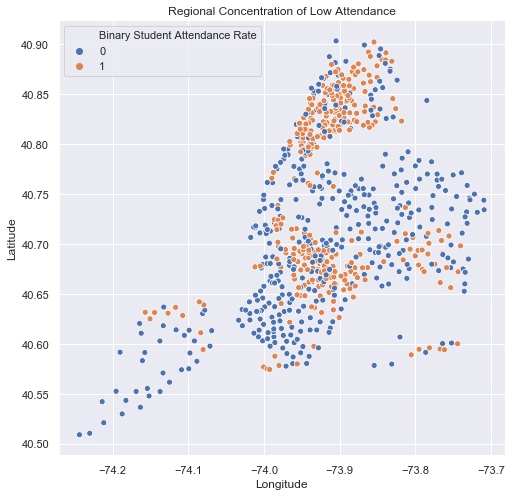

In [36]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='Longitude', y='Latitude', data=features_gbc, hue='Binary Student Attendance Rate')
plt.title("Regional Concentration of Low Attendance")
plt.show()

### Classification Model Conclusions

We couldn't compare cross-validation scores between these two models but based on the prediction scores of these two models, the Gradient Boosted Classifier seems to a better model to use. It satisfies our success metric with 98% accuracy and minimizes both type I and type II errors relative to the Random Forest model with less than 6% error on both types.

# Interpretation of Factors influencing Prediction of Student Attendance Rate

_Gradient Boosted Classifier_

The Gradient Boosted was highly accurate as it scored a 98.10% with 0% type II errors and 4.5% type I error. From these numbers I believe that this model is an incredibly reliable model for identifying underperforming schools that have unsatisfactory attendance rates. The most important variables consist of demographic information, multiple school performance scores, economic need index, english/ math proficiency, school income and a collection of specific cities and districts. A lot of this information is repetitive of what we've learned from our regression models. Certain demographic correlate with the economic situation, quality of education, and support systems available in certain areas. There are more variables reflecting the school's quality in this model such as "Strong Family-Community Ties Rating", however this is simply reinforcing the generic idea that the support systems and relationship with the community is very important in education and for kids going to school.

Some new information we've learned here is that school income plays an important role. This seems trivial, but it wasn't as significant in our regression models, although it was observed. Longitude and latitude are shown as important here, which reinforces the idea that certain regions may correlate with better or worse educational conditions.

# Model Biases and Weakness 

There are biases and weaknesses in this model that need to be addressed for the sake of improvement in the future.

Firstly, when cleaning the data, I purposefully dropped over 100 columns of dummy variables that had extremely specific information on grade, demographic, certain test scores, etc. These columns were mostly incomplete but we still lost a lot of information.

Second, our final data set consisted of 790 rows of information. This isn't a very large data set. This wasn't very problematic in our data analysis, but it could lead to overfitting of our model to this New York data set. In retrospect, this probably isn't a bad thing, considering this model is very specific to New York City data anyway. Many of our predictor variables are districts, and cities. This makes our model very specific to New York. Thus it isn't a reliable model for other states.

Many of these variables look like they’re from surveys so there might be lots of bias in the questionnaires such as misreporting or leading questions. These variables include "Supportive School Environment %" and "Trust %". It's not clear how PASSNYC described this data quantitatively and how they rated it. Furthermore, the variable is a bit obscure as we don't know how they defined an ambiguous term like "Trust".

The Economic Need Index variable is a black box rating system that PASSNYC derived to rate how much a given school needs external support. All our models rely on this data, but we don't know how it was calculated, so in a sense we're putting our trust in something we don't completely understand.

Finally, when validating the assumption of the OLS regression model, we observe a few outliers in the distribution and scatterplot of the residual errors that require further investigation. However, overall the errors had a normal distribution and homogenous variance, so the model seems reliable.

# Improvements


In the future, we can improve data collection techniques when collecting specific information on a school’s grade, demographic and test scores by ensuring that the information is completely filled out. At an administrative level schools can require the documentation of such information for research purposes. This way we'll have more complete information for our predictors, and we won't have to drop as much information. We could also ignore some of that information altogether, since the time and effort of collecting that information isn't worth the benefits.

We can also collect more representative information of school quality, income, community economic and health. Which can be used in any region in the United States for modelling. And then we can train our data based on these factors, rather that cities, to make our model more reliable across the country. However, the city and district specific information is also very important when considering specific regions or states, because problems vary from state to state and it would be bad to rely on a "one-color-fits-all" model.

Finally, as a data scientist it would be extremely helpful to have a complete access to the meta-data on methodology, term definitions, survey questions and how the ratings and index were calculated. This way we can be confident in our predictions and be able to justify all our predictors, rather than relying on "black box" variables.